In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-4:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)

import seq_loader
import aims_analysis as aims

# I apologize in advance that loading in the therapeutic data is messy
Just run all of these next 4 windows if you want to recreate my analysis. Will work on cleaning this up as well, but for now, it works

In [2]:
# LOAD IN THE NEW THERAPEUTIC TEST DATA
adimab_data=seq_loader.getAdimab()

adi_heavy=[adimab_data['cdrH1_aa'].values,adimab_data['cdrH2_aa'].values,adimab_data['cdrH3_aa'].values]
adi_light=[adimab_data['cdrL1_aa'].values,adimab_data['cdrL2_aa'].values,adimab_data['cdrL3_aa'].values]
adi_seqs=np.vstack((adi_light,adi_heavy))

# Now sort it into two separate groups for classification
low_react=adimab_data[adimab_data["ELISA"] < 1.2]

x=adimab_data[adimab_data["ELISA"] >= 1.2]
mid_react=x[x["ELISA"] < 2.0]

high_react=adimab_data[adimab_data["ELISA"] >= 2]
poly_adi=np.vstack((mid_react,high_react))
mono_adi=low_react.values

# Load in AA Keys
AA_key,AA_num_key,AA_num_key_new,props=aims.get_props()

In [3]:
# GET NEW SabDab Therapeutic Test Data
adimab_supp,sabDab_data=seq_loader.getSabDab()

sab_heavy=[sabDab_data['cdrH1_aa'].values,sabDab_data['cdrH2_aa'].values,sabDab_data['cdrH3_aa'].values]
sab_light=[sabDab_data['cdrL1_aa'].values,sabDab_data['cdrL2_aa'].values,sabDab_data['cdrL3_aa'].values]
sabDab_seqs=np.vstack((sab_light,sab_heavy))

# Now sort it into two separate groups for classification
y=sabDab_data[sabDab_data["Highest_Clin_Trial (Jan '20)"] == 'Approved']
sab_approve=y[y["Est. Status"] != 'Discontinued']
sab_discont=sabDab_data[sabDab_data["Est. Status"] == 'Discontinued']

x=sabDab_data[sabDab_data["Highest_Clin_Trial (Jan '20)"] != 'Approved']
phases=x[x["Est. Status"] != 'Discontinued']

num_accept=np.shape(sab_approve)[0]
num_phase=np.shape(phases)[0]

poly_adi=np.vstack((sab_approve,phases))
mono_adi=sab_discont.values

In [4]:
new_adimab=pandas.concat([adimab_data,adimab_supp['Highest_Clin_Trial (Jan \'20)'],adimab_supp['Est. Status']],axis=1)
# Now sort it into two separate groups for classification
y=new_adimab[new_adimab["Highest_Clin_Trial (Jan '20)"] == 'Approved']
adi_approve=y[y["Est. Status"] != 'Discontinued']
adi_discont=new_adimab[new_adimab["Est. Status"] == 'Discontinued']

x=new_adimab[new_adimab["Highest_Clin_Trial (Jan '20)"] != 'Approved']
adi_phases=x[x["Est. Status"] != 'Discontinued']


approve_h=np.vstack((adi_approve.values[:,1:4],sab_approve.values[:,1:4]))
discont_h=np.vstack((adi_discont.values[:,1:4],sab_discont.values[:,1:4]))
approve_l=np.vstack((adi_approve.values[:,5:8],sab_approve.values[:,4:7]))
discont_l=np.vstack((adi_discont.values[:,5:8],sab_discont.values[:,4:7]))

approve_all=np.transpose(np.hstack((approve_l,approve_h)))
discont_all=np.transpose(np.hstack((discont_l,discont_h)))

In [5]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 16}
COLOR = 'black'
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

mpl.rc('font', **font)

Text(0, 0.5, 'AA Position')

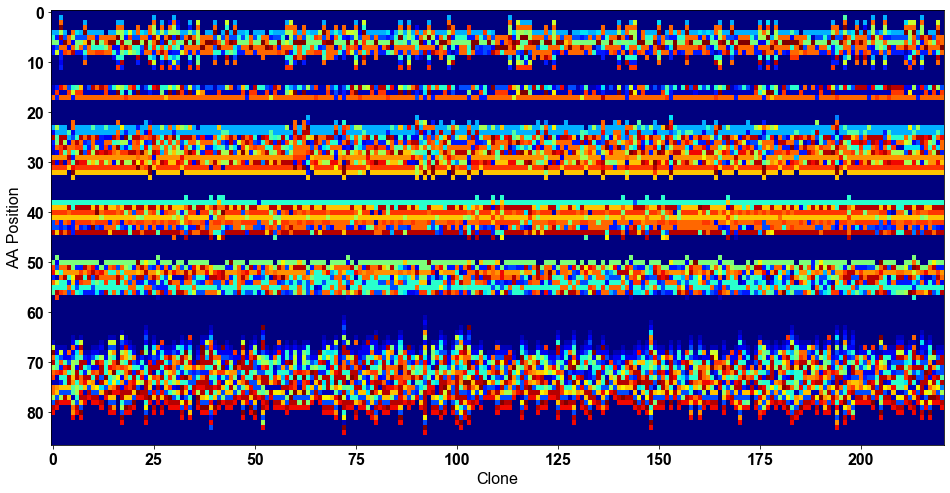

In [6]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))

# Generate two types of matrices: 
# 1. PCA - matrices with float values correlated with hydrophobicity
# 2. MI - matrices that use integer values 1 to 21, randomly assigned
approve_PCA,discont_PCA=aims.gen_tcr_matrix(approve_all,pre_mono=discont_all,key=AA_num_key_new,binary=True)
approve_MI,discont_MI=aims.gen_tcr_matrix(approve_all,pre_mono=discont_all,key=AA_num_key,binary=True)

# Stack the full matrices for nice visualization
total_dat = np.vstack((approve_MI,discont_MI))
matrix=ax[0,0].imshow(np.transpose(total_dat[:,:]), interpolation='nearest', aspect='auto',cmap=cm.jet)

ax[0,0].set_xlabel('Clone')
ax[0,0].set_ylabel('AA Position')
# Optionally save the figure
#fig.savefig('fullData_Matrix.pdf',format='pdf',dpi=500)

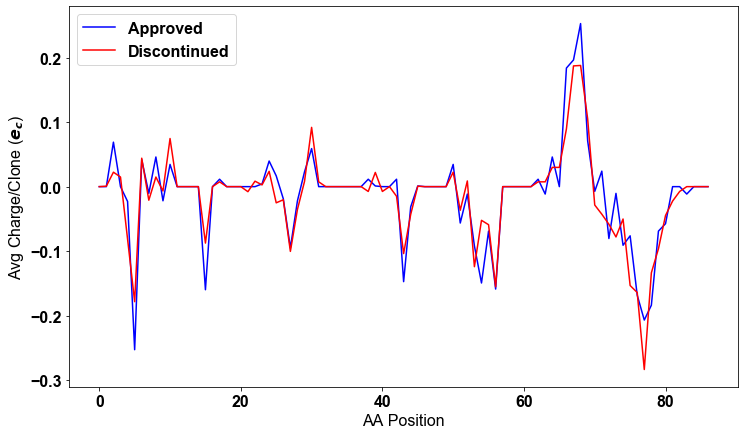

In [7]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(12,7))
# Note, these two sections are pretty slow as well
p_approve,p_approve_stdev=aims.gen_dset_props(approve_MI,stdev=True)
p_discont,p_discont_stdev=aims.gen_dset_props(discont_MI,stdev=True)

# p_poly has all position-sensitive plots of the biophysical properties used in this study.
# Property 2 is "charge" and then everything after that follows the order of the properties 
# in supplemental table 1. Kidera 7 is prop = 12. Hydrophobicity in Supp8B is prop=1
prop = 2

pl.plot(p_approve[prop],'b')
pl.plot(p_discont[prop],'r')

ax[0,0].set_xlabel('AA Position')
#ax[0,0].set_ylabel('Net Hydrophobicity (AU)')
ax[0,0].set_ylabel('Avg Charge/Clone ($e_c$)')
pl.legend(['Approved','Discontinued'])

In [8]:
# This is our separate, classification portion of analysis
# Both LDA mode analyses live here
import aims_classification as classy

In [9]:
# Re-Run this command,since it is fast anyway
# Really running it here for the "MatrixSize" variable
x,y,MatrixSize = aims.gen_tcr_matrix(approve_all,pre_mono=discont_all,binary=True,return_Size=True)

num_approve = np.shape(approve_all)[1]
num_discont = np.shape(discont_all)[1]

# Pretty slow step when dealing with large matrix (full/parsed data)
numVects = 15
acc_all,weights,cols,indices,mda_all,dropped = classy.do_linear_split(discont_all,approve_all,giveSize = MatrixSize, matSize = numVects)
# Print out the accuracy
print(acc_all)

0.7692307692307693


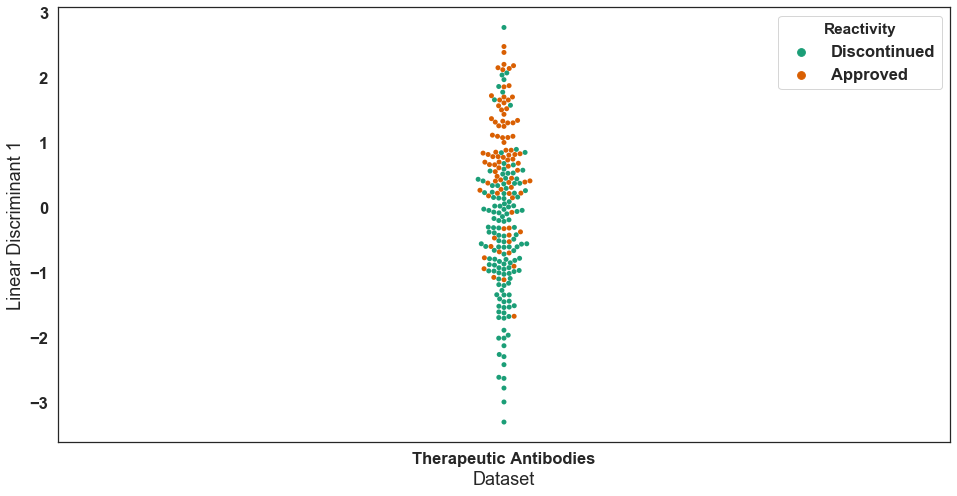

In [10]:
# Seaborn plots look nicer for these LDA figures
fig = pl.figure(figsize = (16, 8))
dset = ["Therapeutic Antibodies" for x in range(num_discont + num_approve)]
reacts = ["Discontinued" for x in range(num_discont)] + ["Approved" for x in range(num_approve)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
     'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
zz = sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
#pl.savefig('thera_LDA.pdf',format='pdf')

These printed propery names should be the x-axis lables (in order):
['Bulk', 'Kid1', 'Hot31', 'Hot40', 'Hot44', 'Kid7', 'Hot35', 'Hot12', 'Hot13', 'Kid9', 'Hot5', 'Kid3']


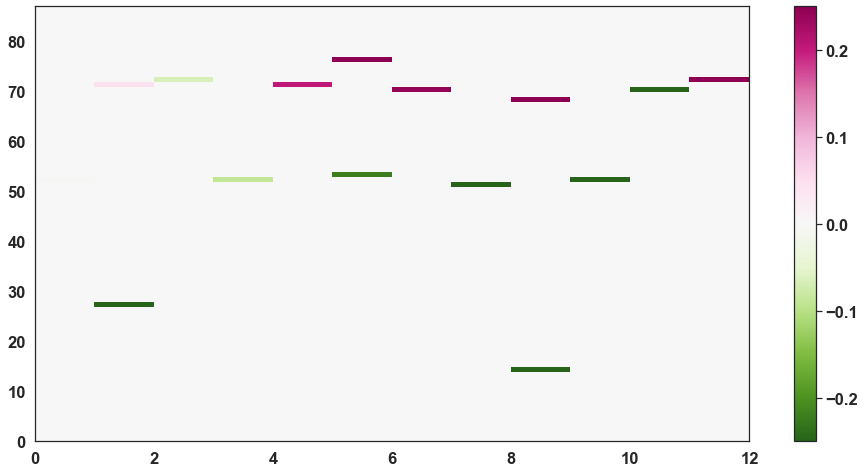

In [11]:
# A lot of code here, but the end goal is to print out both the 
# names and the locations of the top properties used to
# generate the LD1
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# How many properties do you want to show?
# Make sure this isn't larger than "NumVects"
numTop = 15
num_locs = int(sum(MatrixSize))
# Get the column headings:
col_heads = cols[indices]
norm_weights=weights/np.linalg.norm(weights)
# Put them into a vector
cdr_loc = [int(i.split('-')[1]) for i in col_heads]
prop = [i.split('-')[0] for i in col_heads]
# Take the outputs from do_linear_split and prepare them for analysis
a1 = np.transpose(np.vstack((cdr_loc,prop,abs(norm_weights[0]))))
a2 = np.transpose(np.vstack((cdr_loc,prop,norm_weights[0])))
x = a2[a1[:,2].argsort()]
# x is sorted backwards, hence the "-numTop"
prop10 = x[-numTop:,1]
cdr10 = [int(a) for a in x[-numTop:,0]]
diff10 = [float(a) for a in x[-numTop:,2]]
a = 0
for i in np.arange(len(prop10)):
    uniq = True
    if i == 0:
        prop_numeric = 1
        uniq_prop_label = [prop10[i]]
        a = a + 1
    else:
        spot = 0
        for j in uniq_prop_label:
            if prop10[i] == j:
                uniq =  False
                if type(prop_numeric) == int:
                    a_old = a
                else:
                    a_old = prop_numeric[spot]
            spot = spot+1
                
    if uniq and i != 0:
        prop_numeric = np.vstack((prop_numeric,1+a))
        uniq_prop_label = np.vstack((uniq_prop_label,prop10[i]))
        a = a+1
    elif i != 0:
        prop_numeric = np.vstack((prop_numeric,a_old))
prop_num2 = [a[0] for a in prop_numeric]
prop_label2 = [a[0] for a in uniq_prop_label]

diff_mat = np.zeros((max(prop_num2),num_locs))
for i in np.arange(numTop):
    x_pos = prop_num2[i]-1
    y_pos = cdr10[i]-1
    diff_mat[x_pos,y_pos] = diff_mat[x_pos,y_pos] + diff10[i]

x=ax[0,0].pcolormesh(np.transpose(diff_mat),vmin = -0.25, vmax = 0.25, cmap=cm.PiYG_r)
pl.colorbar(x)
print('These printed propery names should be the x-axis lables (in order):')
print(prop_label2)
#pl.savefig('thera_15mat.pdf',format='pdf')

In [12]:
# To re-create figure 6A, we need to load in all of the naturally-derived polyreactivity data
[mono_all,poly_all,mono,poly]=seq_loader.getBunker()
[mono_jennaAll,poly_jennaAll,mono_jenna,poly_jenna]=seq_loader.getJenna()
[mono_HugoAll,poly_HugoAll,mono_Hugo,poly_Hugo]=seq_loader.getHugo()
[mono_HugNat_all,poly_HugNat_all,mono_HugNat,poly_HugNat]=seq_loader.getHugo_Nature()
[mono_PLOS,poly_PLOS]=seq_loader.getHugo_PLOS()
[mono_HugNat_allCNT,poly_HugNat_allCNT,mono_HugNatCNT,poly_HugNatCNT] = seq_loader.getHugo_NatCNTRL()

parse_mono=np.hstack((mono,mono_jenna,mono_Hugo,mono_HugNat,mono_HugNatCNT,mono_PLOS))
parse_poly=np.hstack((poly,poly_jenna,poly_Hugo,poly_HugNat,poly_HugNatCNT,poly_PLOS))

In [13]:
# Re-Run this command,since it is fast anyway
# Really running it here for the "MatrixSize" variable
x,y,MatrixSize = aims.gen_tcr_matrix(parse_poly,pre_mono=parse_mono,binary=True,return_Size=True)

num_mono = np.shape(parse_mono)[1]
num_poly = np.shape(parse_poly)[1]

# Pretty slow step when dealing with large matrix (full/parsed data)
numVects = 75
acc_nat,weights_nat,cols_nat,indices_nat,mda_nat,did_drop = classy.do_linear_split(parse_mono,parse_poly,ridCorr = True, giveSize = MatrixSize, matSize = numVects)
# Print out the accuracy
print(acc_nat)

0.763744427934621


# Try to see if polyreactivity can predict therapeutic approval

In [14]:
# So now we need to recreate the data that we classify on for the therapeutic data (with "get_bigass_matrix")
# and then apply the linear weights generated in the above cell
matsize=75
window=1

discont_Big = classy.get_bigass_matrix(discont_all,giveSize = MatrixSize)
approve_Big = classy.get_bigass_matrix(approve_all,giveSize = MatrixSize)

discont_apply=classy.apply_pretrained_LDA(discont_Big,did_drop,indices_nat,weights_nat)
approve_apply=classy.apply_pretrained_LDA(approve_Big,did_drop,indices_nat,weights_nat)

apply_classifier = np.vstack((approve_apply,discont_apply))
mda_thera = apply_classifier

approve_dim=np.shape(approve_apply)[0]
discont_dim=np.shape(discont_apply)[0]

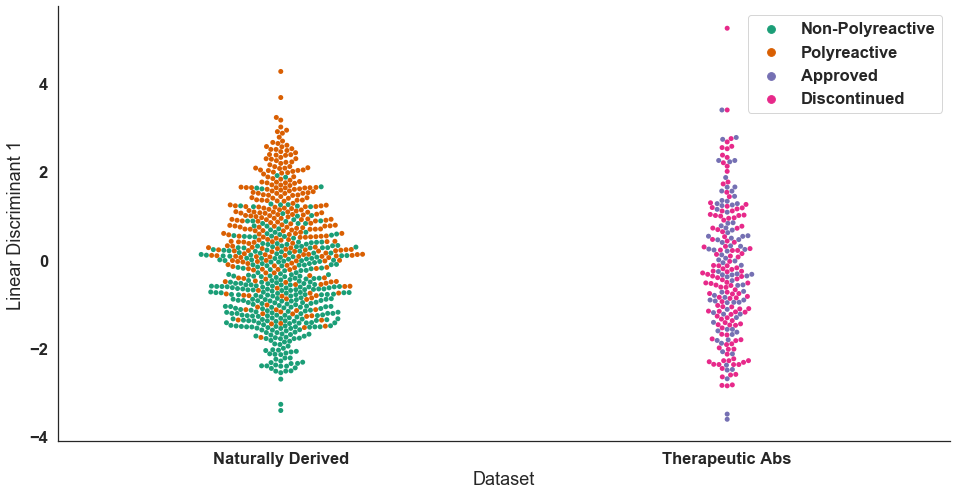

In [15]:
names = ["Naturally Derived" for x in range(num_mono+num_poly)] + ["Therapeutic Abs" for x in range(approve_dim+discont_dim)]
full_dset = np.vstack((mda_nat,mda_thera))
reacts = ["Non-Polyreactive" for x in range(num_mono)] + ["Polyreactive" for x in range(num_poly)] + ["Approved" for x in range(approve_dim)] + ["Discontinued" for x in range(discont_dim)]

fig = pl.figure(figsize = (16, 8))
d1 = {'Dataset': names, 'Linear Discriminant 1': full_dset.reshape(len(full_dset)),
     'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
# Note, I did edit colors outside of python
zz = sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")

sns.despine()
zz.legend_.remove()
pl.legend(loc='upper right')
#pl.savefig('LDA_hiv_thera.pdf',format='pdf')

# OR INSTEAD TRY TO VISUALIZE CROSSOVER BTWN NATURAL AND THERA POLYREACTIVITY

In [16]:
# So now we need to recreate the data that we classify on for the therapeutic data (with "get_bigass_matrix")
# and then apply the linear weights generated in the above cell
approve_adi_F=np.transpose(np.hstack((adi_approve.values[:,5:8],adi_approve.values[:,1:4])))
discont_adi_F=np.transpose(np.hstack((adi_discont.values[:,5:8],adi_discont.values[:,1:4])))

approve_ELISAs=adi_approve["ELISA"]; approve_PSR=adi_approve["Poly-Specificity Reagent (PSR) SMP Score (0-1)"]
discont_ELISAs=adi_discont["ELISA"]; discont_PSR=adi_discont["Poly-Specificity Reagent (PSR) SMP Score (0-1)"]

matsize=75
window=1

discont_Big = classy.get_bigass_matrix(discont_adi_F,giveSize = MatrixSize)[:,indices_nat]
approve_Big = classy.get_bigass_matrix(approve_adi_F,giveSize = MatrixSize)[:,indices_nat]

discont_apply=np.matmul(discont_Big,np.transpose(weights_nat)); discont_dim=np.shape(discont_apply)[0]
approve_apply=np.matmul(approve_Big,np.transpose(weights_nat)); approve_dim=np.shape(approve_apply)[0]

apply_classifier = np.vstack((approve_apply,discont_apply))
mda_thera = apply_classifier

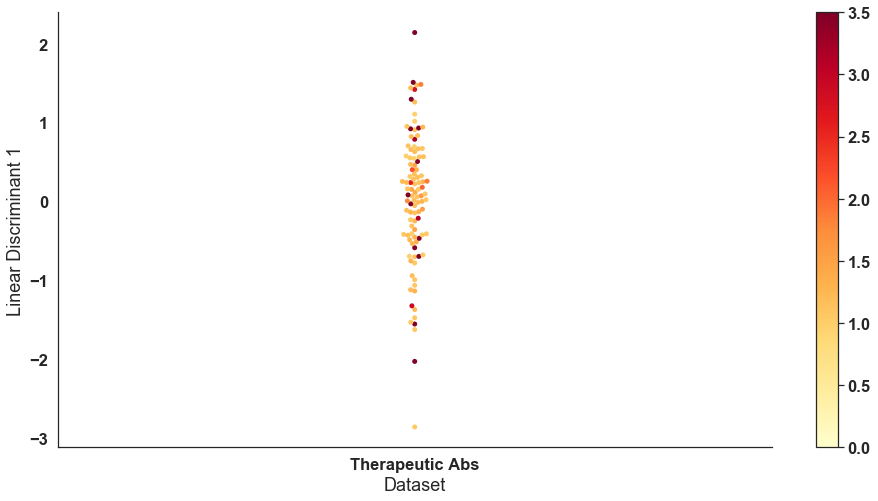

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
reacts = np.hstack((approve_ELISAs,discont_ELISAs))

names = ["Therapeutic Abs" for x in range(approve_dim+discont_dim)]

fig = pl.figure(figsize = (16, 8))
d1 = {'Dataset': names, 'Linear Discriminant 1': mda_thera.reshape(len(mda_thera)),
     'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)

#cmap    = sns.dark_palette(ZZ, reverse=False, as_cmap=True )
#cmap = sns.diverging_palette(58, 15, s=99, l=50,n=20,as_cmap = True)
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=reacts.max()-10)
colors = {}
for cval in reacts:
    colors.update({cval : cmap(norm(cval))})

zz = sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = colors)

sns.despine()
zz.legend_.remove()

norm = mpl.colors.Normalize(vmin=0, vmax=reacts.max()-10)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
pl.colorbar(sm, ticks=np.linspace(0,reacts.max()-10,8))
             #boundaries=np.arange(-0.05,2.1,.1))

#pl.legend(loc='upper right')
#pl.savefig('LDA_NatpolyVsTherapoly.pdf',format='pdf')